In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [9]:
client

Client Scheduler: tcp://10.148.1.103:54672 Dashboard: http://10.148.1.103:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [10]:
#root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

In [11]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max=2, verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home/c11-data/Test_aponte/jetn/jet_cfg1_wp75_4km_1500a2000j_itide/
Found 2 segments
Found 2 grid files
Found 4 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


In [12]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [13]:
t0 = 1550
t1 = 1565
tmid = (t0+t1)/2
flt_id = 225

In [14]:
V = ['u', 'v']
dij = 1
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,14400,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 21 GB


In [7]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

ds = r['surf']#.assign_coords(time=ds.time_counter)

dxy = 4
dsi = ds.assign_coords(time=ds.time_counter).sel(time=slice(1500,1600)).isel(s_rho_slice0=0)
dsi = dsi.assign_coords(x_rho=dsi.x_rho*dxy,y_rho=dsi.y_rho*dxy,x_u=dsi.x_u*dxy,y_v=dsi.y_v*dxy)

In [15]:
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [16]:
ds = ds.persist()

In [17]:
ds['x_u'] = ds['x_u']/1000

In [18]:
ds['y_rho'] = ds['y_rho']/1000

In [19]:
Time = flt1.loc[t0:t1].index
dsi = ds.u.sel(time=slice(1500,1600))

In [20]:
dsg = (dsi.shift(time=1)+dsi)/2

In [21]:
dst = dsg.sel(time=slice(t0-2/(12*24),t1))

In [22]:
ds_zoom = dst.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40))

In [23]:
posmean = flt1[['x','y']].loc[tmid] 
xmean,ymean = [posmean.x,posmean.y]
xlim = [flt1['x'].loc[t0:t1].min()*4,flt1['x'].loc[t0:t1].max()*4]
x0,y0 = [flt1['x'].loc[t0],flt1['y'].loc[t0]]

In [14]:
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [56]:
dsu = dst.sel(y_rho=ymean,x_u=xmean,method='nearest')

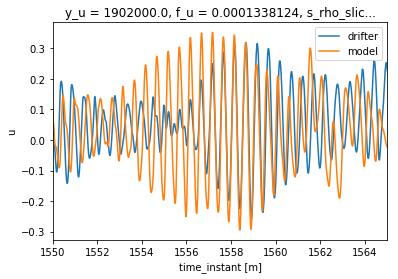

In [41]:
flt1.loc[t0:t1].u.plot(label='drifter')
dsu.plot(label='model')
plt.legend()

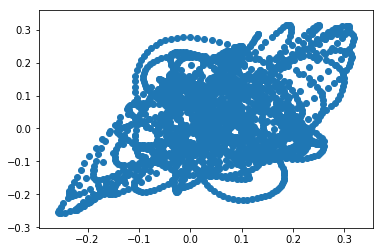

In [17]:
plt.scatter(flt1.loc[t0:t1].u,dsu)

(2161,)

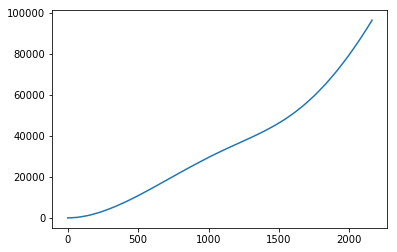

In [21]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [10]:
X,Y = [np.around(flt1.xgrid.loc[t0:t1]*4,decimals=0),flt1.ygrid.loc[t0:t1]*4]

In [27]:
dsu_time = dst.sel(time=tmid,method='nearest').compute()

In [26]:
dsu_space = dsu_time.sel(y_rho=flt1.loc[t0:t1].y.values,method='nearest').compute()

In [29]:
dsu_space = dus_space.sel(x_u=flt1.loc[t0:t1].x.values,method='nearest').compute()

In [32]:
DS=[]
for t in flt1.loc[t0:t1].index:
    DS.append(dsu_time.sel(y_rho=flt1.loc[t].y,x_u=flt1.loc[t].x,method='nearest').values)

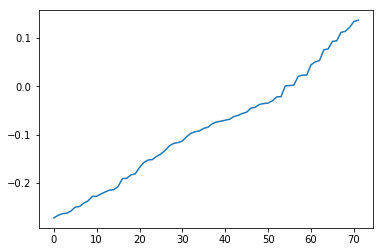

In [52]:
plt.plot(np.unique(DS))

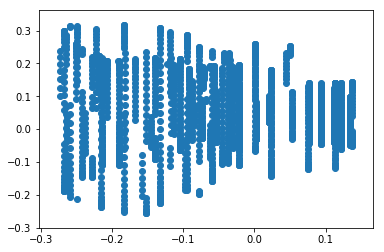

In [50]:
plt.scatter(DS,flt1.loc[t0:t1].u)

(Text(0.5,0,'$x_{\\rho}$'), Text(0,0.5,'$y_{\\rho}$'))

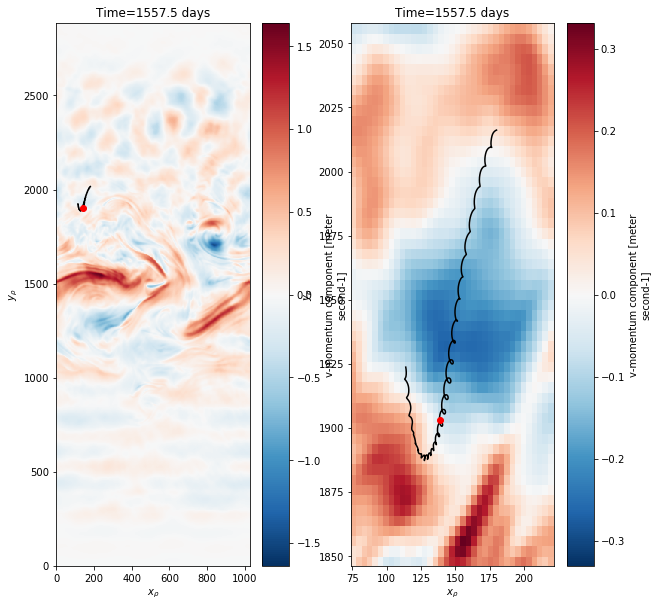

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
#Dsu.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
#        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).plot(ax=ax)
dsi.u.sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_aspect('equal');ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
ax = fig.add_subplot(1,2,2)
dsi.u.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')

Text(0.5,0.98,'Time=1557.5 days')

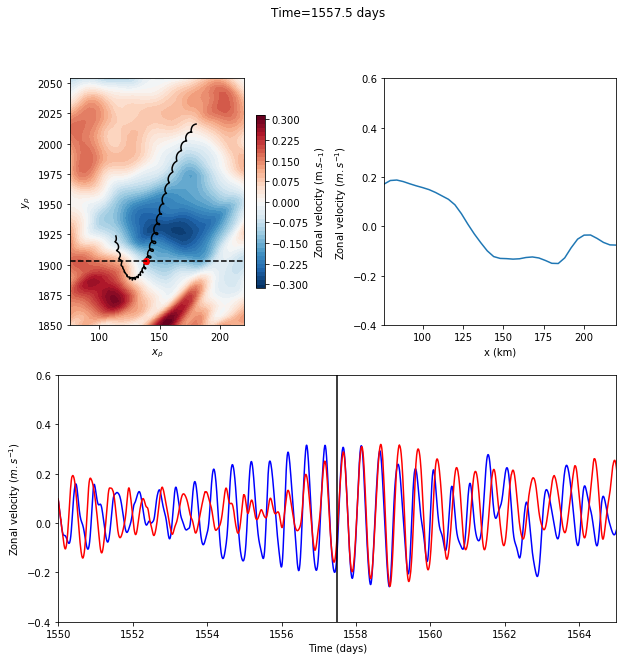

In [24]:
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.2)
ax = plt.subplot(grid[0,0])
cs = ds_zoom.sel(time=tmid,method='nearest').plot.contourf(ax=ax,add_colorbar=False,levels=50)
plt.colorbar(cs,shrink=0.7,label=r'Zonal velocity (m.$s_{-1}$)')
#ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k',title=None)
flt1.loc[t0:t1].plot(x='x',y='y',ax=ax,kind='line',c='k',xlim=(76.,220.),title=None,legend=None)
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.axhline(y=ymean,c='k',linestyle='--')
ax.set_aspect('equal')
ax.set_title('')
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
ax = plt.subplot(grid[0,1])
dst.sel(time = tmid,y_rho=ymean,method='nearest').plot(ax=ax,xlim=(76.,220.),ylim=(-0.4,0.6))
ax.set_xlabel('x (km)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
ax.set_title('')
ax = plt.subplot(grid[1,:])
dst.sel(x_u=xmean,y_rho=ymean,method='nearest').plot(ax=ax,c='b',xlim=(t0,t1),ylim=(-0.4,0.6))
flt1[['u']].plot(ax=ax,c='r',xlim=(t0,t1),ylim=(-0.4,0.6),title=None,legend=None)
ax.axvline(x=tmid,c='k')
ax.set_xlabel('Time (days)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
ax.set_title('')

fig.suptitle('Time=%s days'%tmid)

In [82]:
cs.set_ticklabels

AttributeError: 'QuadContourSet' object has no attribute 'set_ticklabels'

In [152]:
print('Time %s'%np.around(1550.00069,decimals=1))

Time 1550.0


In [25]:
def genfig(t,figsize,figdir, overwrite=True,offline=True):
    figname = figdir+'flt225_t%s' %(np.around(t, decimals=2))+'.png'
    if not os.path.isfile(figname) or overwrite:
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            fig = plt.figure(figsize=figsize)
            grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.2)
            ax = plt.subplot(grid[0,0])
            cs = ds_zoom.sel(time=t,method='nearest').plot.contourf(ax=ax,vmax = 0.6,vmin = -0.6,cmap = 'RdBu_r',add_colorbar=False,levels=50)
            plt.colorbar(cs,shrink=0.8,label=r'Zonal velocity (m.$s_{-1}$)')
            #ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k',title=None)
            flt1.loc[t0:t1].plot(x='x',y='y',ax=ax,kind='line',c='k',xlim=(76,220),title=None,legend=None)
            ax.plot(flt1.x.loc[t],flt1.y.loc[t],marker='o',c='r')
            ax.plot(xmean,ymean,c='b',marker='d')
            ax.axhline(y=ymean,c='k',linestyle='--')
            ax.set_aspect('equal')
            ax.set_title('')
            ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
            ax = plt.subplot(grid[1,:])
            dst.sel(x_u=xmean,y_rho=ymean,method='nearest').plot(ax=ax,c='b',xlim=(t0,t1),ylim=(-0.4,0.6))
            flt1[['u']].plot(ax=ax,c='r',xlim=(t0,t1),ylim=(-0.4,0.6),title=None,legend=None)
            ax.axvline(x=t,c='k')
            ax.set_xlabel('Time (days)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
            ax.set_title('')
            ax = plt.subplot(grid[0,1])
            dst.sel(time = t,y_rho=ymean,method='nearest').plot(ax=ax,xlim=(76,220),ylim=(-0.4,0.6))
            ax.set_xlabel('x (km)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
            ax.set_title('')
            fig.suptitle('Time=%s days'%t)
            if offline:
                fig.savefig(figname)
                plt.close()
            m = 1.
    else:
        m = -1.
    return m

In [28]:
Time[::6].size

361

In [29]:
figdir = '/home1/datahome/zcaspar/figs/'
for t in Time[::6] : 
    print(t)
    genfig(t,(10,10),figdir,overwrite=True,offline=True)

1550.0
1550.0417
1550.0833
1550.125
1550.1667
1550.2083
1550.25
1550.2917
1550.3333
1550.375
1550.4167
1550.4583
1550.5
1550.5417
1550.5833
1550.625
1550.6667
1550.7083
1550.75
1550.7917
1550.8333
1550.875
1550.9167
1550.9583
1551.0
1551.0417
1551.0833
1551.125
1551.1667
1551.2083
1551.25
1551.2917
1551.3333
1551.375
1551.4167
1551.4583
1551.5
1551.5417
1551.5833
1551.625
1551.6667
1551.7083
1551.75
1551.7917
1551.8333
1551.875
1551.9167
1551.9583
1552.0
1552.0417
1552.0833
1552.125
1552.1667
1552.2083
1552.25
1552.2917
1552.3333
1552.375
1552.4167
1552.4583
1552.5
1552.5417
1552.5833
1552.625
1552.6667
1552.7083
1552.75
1552.7917
1552.8333
1552.875
1552.9167
1552.9583
1553.0
1553.0417
1553.0833
1553.125
1553.1667
1553.2083
1553.25
1553.2917
1553.3333
1553.375
1553.4167
1553.4583
1553.5
1553.5417
1553.5833
1553.625
1553.6667
1553.7083
1553.75
1553.7917
1553.8333
1553.875
1553.9167
1553.9583
1554.0
1554.0417
1554.0833
1554.125
1554.1667
1554.2083
1554.25
1554.2917
1554.3333
1554.375


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:42628'], ('getitem-0898103475949f1e560ea263de68f3e9', 151)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:57057'], ('getitem-0898103475949f1e560ea263de68f3e9', 1329)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:49355'], ('getitem-0898103475949f1e560ea263de68f3e9', 1588)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:58579'], ('getitem-0898103475949f1e560ea263de68f3e9', 735)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:55889'], ('getitem-0898103475949f1e560ea263de68f3e9', 28)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:53044'], ('getitem-0898103475949f1e560ea263de68f3e9', 1964)
NoneType: None
distributed.scheduler - ERROR - Workers don'

1554.4167
1554.4583
1554.5
1554.5417
1554.5833
1554.625
1554.6667
1554.7083
1554.75
1554.7917
1554.8333
1554.875
1554.9167
1554.9583
1555.0
1555.0417
1555.0833
1555.125
1555.1667
1555.2083
1555.25
1555.2917
1555.3333
1555.375
1555.4167
1555.4583
1555.5
1555.5417
1555.5833
1555.625
1555.6667
1555.7083
1555.75
1555.7917
1555.8333
1555.875
1555.9167
1555.9583
1556.0
1556.0417
1556.0833
1556.125
1556.1667
1556.2083
1556.25
1556.2917


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:42628'], ('getitem-0898103475949f1e560ea263de68f3e9', 1037)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:47687'], ('getitem-0898103475949f1e560ea263de68f3e9', 2090)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:37873'], ('getitem-0898103475949f1e560ea263de68f3e9', 1678)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:39984'], ('getitem-0898103475949f1e560ea263de68f3e9', 927)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:52247'], ('getitem-0898103475949f1e560ea263de68f3e9', 2068)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:57057'], ('getitem-0898103475949f1e560ea263de68f3e9', 1286)
NoneType: None
distributed.scheduler - ERROR - Workers d

1556.3333
1556.375
1556.4167
1556.4583
1556.5
1556.5417
1556.5833
1556.625
1556.6667
1556.7083
1556.75
1556.7917
1556.8333
1556.875
1556.9167
1556.9583
1557.0
1557.0417
1557.0833
1557.125
1557.1667
1557.2083
1557.25
1557.2917
1557.3333
1557.375
1557.4167
1557.4583
1557.5
1557.5417
1557.5833
1557.625
1557.6667
1557.7083


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:42628'], ('getitem-0898103475949f1e560ea263de68f3e9', 1037)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:47687'], ('getitem-0898103475949f1e560ea263de68f3e9', 2090)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:37873'], ('getitem-0898103475949f1e560ea263de68f3e9', 1678)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:49051'], ('getitem-0898103475949f1e560ea263de68f3e9', 1561)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:39984'], ('getitem-0898103475949f1e560ea263de68f3e9', 927)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:57057'], ('getitem-0898103475949f1e560ea263de68f3e9', 1286)
NoneType: None
distributed.scheduler - ERROR - Workers d

1557.75
1557.7917
1557.8333
1557.875
1557.9167
1557.9583
1558.0
1558.0417
1558.0833
1558.125
1558.1667
1558.2083
1558.25
1558.2917
1558.3333
1558.375


distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:42628'], ('getitem-0898103475949f1e560ea263de68f3e9', 1037)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:47687'], ('getitem-0898103475949f1e560ea263de68f3e9', 2090)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:50848'], ('getitem-0898103475949f1e560ea263de68f3e9', 1834)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:52268'], ('getitem-0898103475949f1e560ea263de68f3e9', 132)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:37873'], ('getitem-0898103475949f1e560ea263de68f3e9', 1678)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://10.148.1.10:50848'], ('getitem-0898103475949f1e560ea263de68f3e9', 1052)
NoneType: None
distributed.scheduler - ERROR - Workers d

1558.4167
1558.4583
1558.5
1558.5417
1558.5833
1558.625
1558.6667
1558.7083
1558.75
1558.7917
1558.8333
1558.875
1558.9167
1558.9583
1559.0
1559.0417
1559.0833
1559.125
1559.1667
1559.2083
1559.25
1559.2917
1559.3333
1559.375
1559.4167
1559.4583
1559.5
1559.5417
1559.5833
1559.625
1559.6667
1559.7083
1559.75
1559.7917
1559.8333
1559.875
1559.9167
1559.9583
1560.0
1560.0417
1560.0833
1560.125
1560.1667
1560.2083
1560.25
1560.2917
1560.3333
1560.375
1560.4167
1560.4583
1560.5
1560.5417
1560.5833
1560.625
1560.6667
1560.7083
1560.75
1560.7917
1560.8333
1560.875
1560.9167
1560.9583
1561.0
1561.0417
1561.0833
1561.125
1561.1667
1561.2083
1561.25
1561.2917
1561.3333
1561.375
1561.4167
1561.4583
1561.5
1561.5417
1561.5833
1561.625
1561.6667
1561.7083
1561.75
1561.7917
1561.8333
1561.875
1561.9167
1561.9583
1562.0
1562.0417
1562.0833
1562.125
1562.1667
1562.2083
1562.25
1562.2917
1562.3333
1562.375
1562.4167
1562.4583
1562.5
1562.5417
1562.5833
1562.625
1562.6667
1562.7083
1562.75
1562.7917
15

In [ ]:
def genfig(i, ds, v, flt, n, size, overwrite=True, offline=True):
    
    figname = figdir+'float_%s_t%05d_%s' %(v, n, size)+'.png'
    
    if not os.path.isfile(figname) or overwrite:
        time = ds['time_instant'].values
        
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            flti = flt.loc[i]
            fig = plt.figure(figsize=(10,10))
            grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)
    
            ax = plt.subplot(grid[2, :])
    #off1 = .5
            ax.plot(flt.index,flt.u)
            ax.axvline(x=i, color='k', lw=1)
            ax.set_xlabel('Time (days)');ax.set_ylabel(r'Zonal velocity ($m.s^{-1}$)')
            ax = plt.subplot(grid[:2, :])    
            ax.plot(flt.x, flt.y)
   
            ax.plot(flti.x, flti.y, marker='d', ms=8, 
                    markeredgecolor='k')
            ds.plot.contourf(ax=ax, levels = np.linspace(-1,0,20), cmap='RdBu_r')
            ax.set_xlabel(r'$x_\rho$');ax.set_ylabel(r'$y_\rho$')
            ax.set_title(r'Time$\simeq$%sdays'%np.around(i,decimals=1))
            if offline:
                fig.savefig(figname)
                plt.close()
            #
            m = 1.
    else:
        m = -1.
    return m

In [47]:
del ds

In [30]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1290, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", line 1019, in _reconnect
    await self._close()
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/client.py", l